# [ASHRAE - Great Energy Predictor III](https://www.kaggle.com/c/ashrae-energy-prediction/overview)

How much energy will a building consume?


---

Developing energy savings has two key elements: Forecasting future energy usage without improvements, and forecasting energy use after a specific set of improvements have been implemented, like the installation and purchase of investment-grade meters, whose prices continue to fall. One issue preventing more aggressive growth of the energy markets are the lack of cost-effective, accurate, and scalable procedures for forecasting energy use.

**In this competition, you’ll develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.**

With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

> This notebook serves a **preliminary data exploratory analysis** and **preprocessing** training and test dataset into intermediate datasets.

In [1]:
# standard libraries
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import os

In [2]:
raw_data_dir = '../data/01_raw'
os.listdir(raw_data_dir)

['.DS_Store',
 '.gitkeep',
 'building_metadata.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'weather_test.csv',
 'weather_train.csv']

In [3]:
%%time
# read primary training data and test data
train = pd.read_csv(raw_data_dir + '/train.csv')
test = pd.read_csv(raw_data_dir + '/test.csv')

# read complimentary datasets
weather_train = pd.read_csv(raw_data_dir + '/weather_train.csv')
weather_test = pd.read_csv(raw_data_dir + '/weather_test.csv')
building_metadata = pd.read_csv(raw_data_dir + '/building_metadata.csv')

CPU times: user 51.5 s, sys: 11.5 s, total: 1min 3s
Wall time: 1min 10s


In [4]:
# Glimpse of data
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of building_metadata', building_metadata.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of building_metadata (1449, 6)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)


In [5]:
train.memory_usage()

Index                   80
building_id      161728800
meter            161728800
timestamp        161728800
meter_reading    161728800
dtype: int64

In [6]:
test.memory_usage()

Index                 80
row_id         333580800
building_id    333580800
meter          333580800
timestamp      333580800
dtype: int64

In [7]:
# Reduce Memory Size
def reduce_mem_usage(df, verbose=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

building_metadata = reduce_mem_usage(building_metadata)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [8]:
train.dtypes

building_id        int16
meter               int8
timestamp         object
meter_reading    float32
dtype: object

In [9]:
%%time

def autoSetColType(df, tablename='Unknown'):
    """ Convert columns(ID or timestamp) to be in categorical or timestamp
    arg: df: input dataframe
         tablename: table name for printing messages. default 'unknown'
    """
    # timestamp
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
        print(f'datetime converted for {tablename}')
    except:
        print(f'\'timestamp\' column may not exist in {tablename}')
    
    # categorical columns
    if 'building_id' in df.columns:
        df['building_id'] = df['building_id'].astype('category')
    if 'meter' in df.columns:
        df['meter'] = df['meter'].astype('category')
    if 'site_id' in df.columns:
        df['site_id'] = df['site_id'].astype('category')
        

autoSetColType(train, 'train')
autoSetColType(test, 'test')
autoSetColType(building_metadata, 'building_meta')
autoSetColType(weather_train, 'weather_train')
autoSetColType(weather_test, 'weather_test')

datetime converted for train
datetime converted for test
'timestamp' column may not exist in building_meta
datetime converted for weather_train
datetime converted for weather_test
CPU times: user 24.7 s, sys: 5.85 s, total: 30.6 s
Wall time: 35.9 s


In [10]:
test.drop('row_id', axis=1, inplace=True)

> ### dataset memory usage reduced and categorical, timestampe data treated. Ready for exploration!
Note: training dataset has 20M rows, and test dataset has ~42M rows

## Target column distribution

In [11]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [12]:
train.describe(include='all')

,building_id,meter,timestamp,meter_reading
count,20216100.0,20216100.0,20216100,2.021610e+07
unique,1449.0,4.0,8784,NaN
top,1298.0,0.0,2016-12-27 22:00:00,NaN
freq,35136.0,12060910.0,2370,NaN
first,NaN,NaN,2016-01-01 00:00:00,NaN
last,NaN,NaN,2016-12-31 23:00:00,NaN
mean,NaN,NaN,NaN,1.988706e+03
std,NaN,NaN,NaN,1.532159e+05
min,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,1.830000e+01


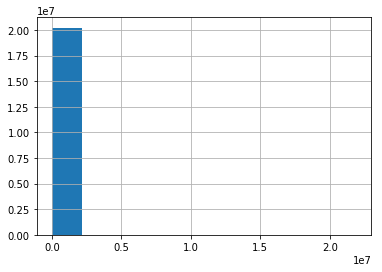

In [13]:
train['meter_reading'].hist()

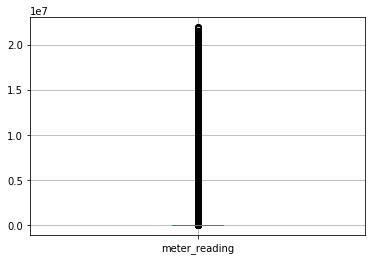

In [14]:
train.boxplot('meter_reading')

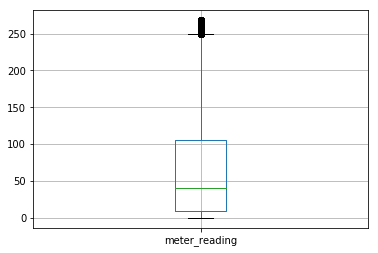

In [15]:
# excluding outliers
train.loc[train['meter_reading']<train['meter_reading'].quantile(0.75)].boxplot('meter_reading')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a93be5ac8>,
      dtype=object)

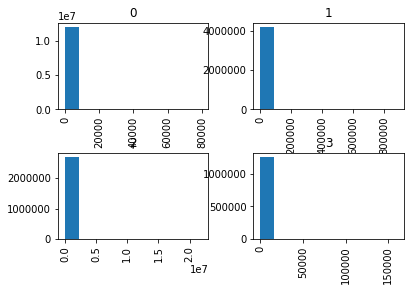

In [16]:
# plot by meter 
train['meter_reading'].hist(by=train['meter'])

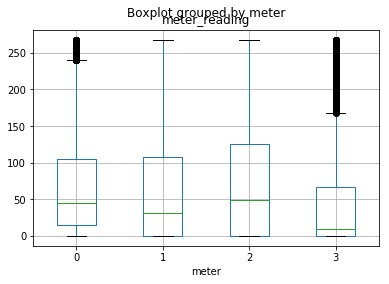

In [17]:
# excluding outliers & by meter
train.loc[train['meter_reading']<train['meter_reading'].quantile(0.75)].boxplot(column='meter_reading', by='meter')

> ### Way too many outliers & Meter readings vary a lot despite same type of meter across buildings

In [18]:
def plotSampleBldMeter(seed=None):
    """ plot
    """
    import random
    
    if seed != None:
        random.seed(seed)
    
    BUILD_ID = random.randint(0, 1448)
    METER = random.randint(0, 3)
    
    print('Sample a building with ID', BUILD_ID, ', meter =', METER)
    
    try:
        sample_train = train.loc[(train['building_id']==BUILD_ID) & (train['meter']==METER)]
        sample_train.plot('timestamp', 'meter_reading', style='.')
    except:
        print(f'Cannot sample building_id = {BUILD_ID} with meter={METER}')
        print('Resample randomly')
        plotSampleBldMeter()

Sample a building with ID 1265 , meter = 1


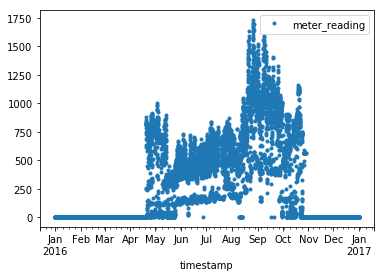

In [19]:
plotSampleBldMeter()

Sample a building with ID 70 , meter = 2
Cannot sample building_id = 70 with meter=2
Resample randomly
Sample a building with ID 1304 , meter = 2
Cannot sample building_id = 1304 with meter=2
Resample randomly
Sample a building with ID 533 , meter = 2
Cannot sample building_id = 533 with meter=2
Resample randomly
Sample a building with ID 561 , meter = 0


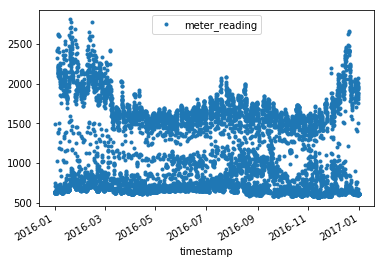

In [20]:
plotSampleBldMeter()

Sample a building with ID 949 , meter = 3
Cannot sample building_id = 949 with meter=3
Resample randomly
Sample a building with ID 777 , meter = 2
Cannot sample building_id = 777 with meter=2
Resample randomly
Sample a building with ID 1397 , meter = 3
Cannot sample building_id = 1397 with meter=3
Resample randomly
Sample a building with ID 1297 , meter = 2


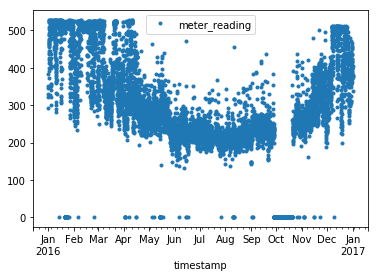

In [21]:
plotSampleBldMeter()

> Meter reading across buildings and meters seem to vary a lot. Assumptions: building type matters to energy consumption and building age and region might affect what kind of energy it primarily uses.

## Building

In [22]:
building_metadata.shape # each building has one row

(1449, 6)

In [23]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [24]:
building_metadata.describe(include='all')

,site_id,building_id,primary_use,square_feet,year_built,floor_count
count,1449.0,1449.0,1449,1449.000000,675.000000,355.000000
unique,16.0,1449.0,16,NaN,NaN,NaN
top,3.0,1448.0,Education,NaN,NaN,NaN
freq,274.0,1.0,549,NaN,NaN,NaN
mean,NaN,NaN,NaN,92111.776398,inf,3.740234
std,NaN,NaN,NaN,110769.950997,31.062500,3.333984
min,NaN,NaN,NaN,283.000000,1900.000000,1.000000
25%,NaN,NaN,NaN,23012.000000,1949.000000,1.000000
50%,NaN,NaN,NaN,57673.000000,1970.000000,3.000000
75%,NaN,NaN,NaN,115676.000000,1995.000000,5.000000


In [25]:
train_df = train.merge(building_metadata, how='left')

In [26]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN


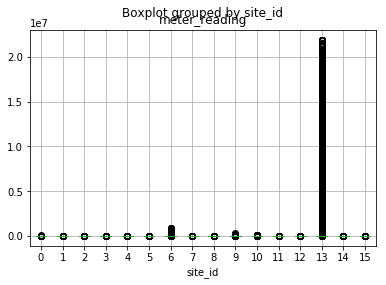

In [27]:
# by site_id
train_df.boxplot(column='meter_reading', by='site_id')

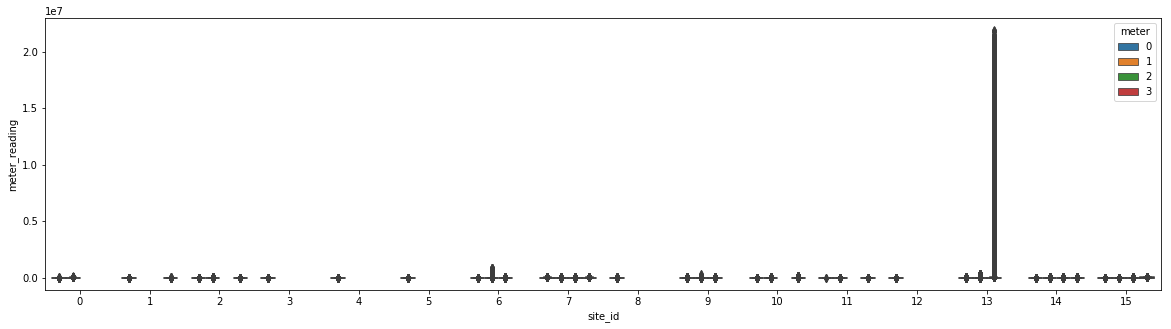

In [28]:
# by site_id & meter
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x='site_id', y='meter_reading', hue='meter', data=train_df)

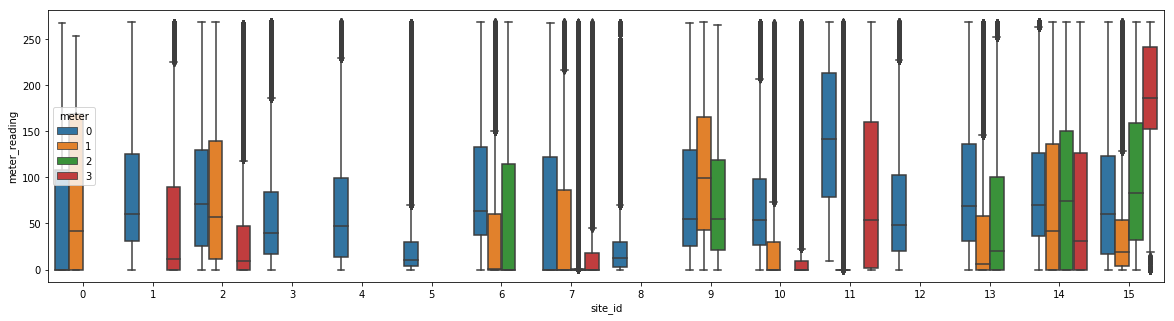

In [29]:
# excluding outliers & by site_id & meter
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x='site_id', y='meter_reading', hue='meter', data=\
            train_df.loc[train_df['meter_reading']<train_df['meter_reading'].quantile(0.75)])

Some sites use only 1~2 types of meter, e.q. site_id = 3, 4, 5, 8, 12

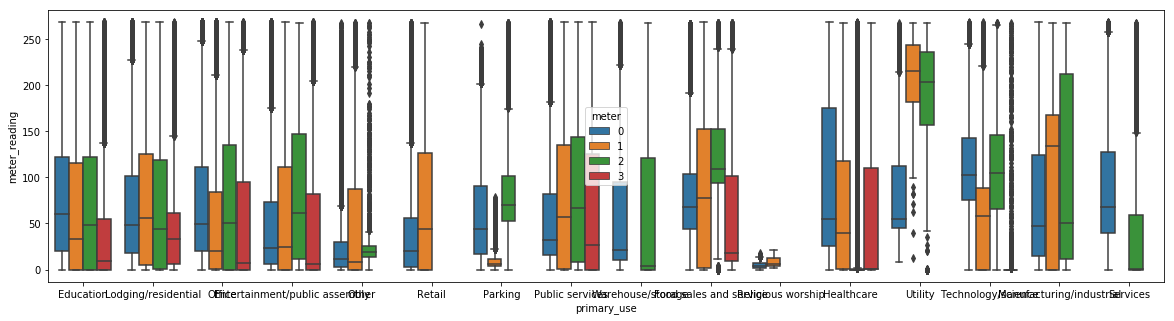

In [30]:
# excluding outliers & by primary use & meter
plt.figure(figsize=(20, 5))
ax = sns.boxplot(x='primary_use', y='meter_reading', hue='meter', data=\
            train_df.loc[train_df['meter_reading']<train_df['meter_reading'].quantile(0.75)])

## Weather

In [31]:
weather_train.shape

(139773, 9)

In [32]:
print(train_df.shape)
train_df = train_df.merge(weather_train, how='left') # inner join
train_df.shape

(20216100, 9)


(20216100, 16)

In [33]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


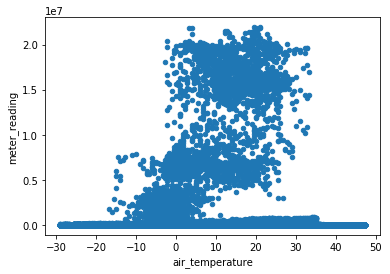

In [34]:
train_df.plot.scatter(x='air_temperature', y='meter_reading')

There seems to be a positive linear relationship between `air_temporature` and `meter_reading`.

Note: Plotting this scatterplot takes a lot of time because the data size is too big whereas there are outliers and missing data (reading=0).

In [35]:
train_df.memory_usage(), train_df.memory_usage().sum()

(Index                 161728800
 building_id            40484752
 meter                  20216292
 timestamp             161728800
 meter_reading          80864400
 site_id                20216868
 primary_use           161728800
 square_feet            80864400
 year_built             40432200
 floor_count            40432200
 air_temperature        40432200
 cloud_coverage         40432200
 dew_temperature        40432200
 precip_depth_1_hr      40432200
 sea_level_pressure     40432200
 wind_direction         40432200
 wind_speed             40432200
 dtype: int64, 1091722912)

### Preprocess for Test

In [36]:
test.head()

,building_id,meter,timestamp
0,0,0,2017-01-01
1,1,0,2017-01-01
2,2,0,2017-01-01
3,3,0,2017-01-01
4,4,0,2017-01-01


In [37]:
print(test.shape)
test_df = test.merge(building_metadata, how='left')
test_df = test_df.merge(weather_test, how='left')
print(test_df.shape)

(41697600, 3)
(41697600, 15)


In [38]:
test_df.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2017-01-01,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,0,2017-01-01,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,0,2017-01-01,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,0,2017-01-01,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,0,2017-01-01,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


## Export preprocessed datasets

In [39]:
"""
%%time
# export preprocessed data to intermediate data folder
intermediate_data_dir = '../data/02_intermediate/'
train_df.to_csv(intermediate_data_dir+'train.csv', index=False)
test_df.to_csv(intermediate_data_dir+'test.csv', index=False)
"""

"\n%%time\n# export preprocessed data to intermediate data folder\nintermediate_data_dir = '../data/02_intermediate/'\ntrain_df.to_csv(intermediate_data_dir+'train.csv', index=False)\ntest_df.to_csv(intermediate_data_dir+'test.csv', index=False)\n"

In [43]:
%%time
intermediate_data_dir = '../data/02_intermediate/'
train_df.to_hdf(intermediate_data_dir + 'intermediate.h5', \
                key='train', format='table')
test_df.to_hdf(intermediate_data_dir + 'intermediate.h5', \
               key='test', format='table')

CPU times: user 2min 57s, sys: 49.8 s, total: 3min 47s
Wall time: 4min 27s
